In [17]:
# =============================================================================
# GLM NEGATIVE BINOMIAL 
# =============================================================================

import os
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import box
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.genmod.families import NegativeBinomial
# --- Nuevas librerías para el análisis espacial ---
import libpysal.weights
from esda.moran import Moran, Moran_Local

# ────────────────────────────────────────────────────────────────────────────────
# Rutas de entrada y salida 
ruta_geoformas = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Inventario_geoformas_karsticas_Dunita.shp"
ruta_contorno  = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Contorno_Dunita.shp"
ruta_dem       = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\Raster\dem_clip.tif"
ruta_slope     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\Raster\pendiente.tif"
ruta_twi       = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\Raster\TWI.tif"
ruta_cover     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Cobertura_final.shp"
ruta_drain     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Drenajes_clip_POT_final.shp"
ruta_fault     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Fallas_lineam.shp"
output_dir     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG"
os.makedirs(output_dir, exist_ok=True)

# ────────────────────────────────────────────────────────────────────────────────
# PASO 1: CARGA DE DATOS 
gdf_points  = gpd.read_file(ruta_geoformas)
gdf_contour = gpd.read_file(ruta_contorno)

# ────────────────────────────────────────────────────────────────────────────────
# PASO 2: GENERAR CUADRÍCULA Y CONTEO 
cell_size = 100
minx, miny, maxx, maxy = gdf_contour.total_bounds
xs = np.arange(minx, maxx, cell_size)
ys = np.arange(miny, maxy, cell_size)
polygons = [box(x, y, x+cell_size, y+cell_size) for x in xs for y in ys]
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=gdf_contour.crs)
grid = gpd.clip(grid, gdf_contour)

join = gpd.sjoin(grid, gdf_points, how='left', predicate='intersects')
counts = join.groupby(join.index).size()
grid['count'] = counts.reindex(grid.index).fillna(0).astype(int)

# ────────────────────────────────────────────────────────────────────────────────
# PASO 3: EXTRAER COVARIABLES ZONALES 
grid['dem_mean']   = [s['mean'] if s and s['mean'] is not None else np.nan for s in zonal_stats(grid, ruta_dem,   stats=['mean'], nodata=-9999)]
grid['slope_mean'] = [s['mean'] if s and s['mean'] is not None else np.nan for s in zonal_stats(grid, ruta_slope, stats=['mean'], nodata=-9999)]
grid['twi_mean']   = [s['mean'] if s and s['mean'] is not None else np.nan for s in zonal_stats(grid, ruta_twi,   stats=['mean'], nodata=-9999)]

# ────────────────────────────────────────────────────────────────────────────────
# PASO 4: UNIR COBERTURA Y CALCULAR DISTANCIAS 
cov_gdf  = gpd.read_file(ruta_cover)[['d_N3_COBER','geometry']].to_crs(grid.crs)
centroids= grid.copy(); centroids['geometry'] = centroids.centroid
cov_join = gpd.sjoin(centroids, cov_gdf, how='left', predicate='within')
grid['cover'] = cov_join['d_N3_COBER'].fillna('None')

drains = gpd.read_file(ruta_drain).to_crs(grid.crs)
faults = gpd.read_file(ruta_fault).to_crs(grid.crs)
union_drains = drains.geometry.unary_union
union_faults = faults.geometry.unary_union
grid['dist_drain'] = centroids.geometry.distance(union_drains)
grid['dist_fault'] = centroids.geometry.distance(union_faults)

# ────────────────────────────────────────────────────────────────────────────────
# PASO 5: PREPARAR DataFrame PARA MODELADO 
df = grid[['count','dem_mean','slope_mean','twi_mean','dist_drain','dist_fault','cover']].copy()
df = df.dropna()
y = df['count'].astype(int)
X_vars = df.drop(columns=['count'])
X_vars = pd.get_dummies(X_vars, columns=['cover'], prefix='cov', drop_first=True)
X = sm.add_constant(X_vars.astype(float))
y = y[X.index]

# ────────────────────────────────────────────────────────────────────────────────
# PASO 6: AJUSTE GLM NEGATIVE BINOMIAL 
model = sm.GLM(y, X, family=NegativeBinomial())
results = model.fit()
print("Resumen del Modelo GLM Binomial Negativo:")
print(results.summary())

# ────────────────────────────────────────────────────────────────────────────────

# PASO 7: CREAR GEO DATAFRAME DE RESULTADOS PARA LA SIGUIENTE CELDA
print("\n--- PASO 7: Creando GeoDataFrame final con resultados del modelo... ---")

# Seleccionamos las celdas del grid original que se usaron en el modelo
grid_model = grid.loc[X.index].copy()

# Añadimos los residuos del modelo como una nueva columna
grid_model['resid_dev'] = results.resid_deviance

print("Variable 'grid_model' creada y lista para ser usada en la siguiente celda.")
# Esta línea de verificación te mostrará todas las columnas disponibles:
print("Columnas disponibles en 'grid_model':", grid_model.columns.to_list())

Resumen del Modelo GLM Binomial Negativo:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                 2426
Model:                            GLM   Df Residuals:                     2400
Model Family:        NegativeBinomial   Df Model:                           25
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3929.7
Date:                Sun, 22 Jun 2025   Deviance:                       485.48
Time:                        20:56:03   Pearson chi2:                 1.04e+03
No. Iterations:                     8   Pseudo R-squ. (CS):            0.08029
Covariance Type:            nonrobust                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

C:\Users\esteb\AppData\Local\Temp\ipykernel_19464\2168116474.py:65: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  union_drains = drains.geometry.unary_union
C:\Users\esteb\AppData\Local\Temp\ipykernel_19464\2168116474.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  union_faults = faults.geometry.unary_union
C:\Users\esteb\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "



--- PASO 10: Calculando el Índice de Moran Global para los Residuos... ---

Resultados del Índice de Moran Global:
  - Índice de Moran (I): 0.2978
  - P-valor (p_sim):   0.0010
  - Z-score (z_sim):   27.9614

  Interpretación: El p-valor es estadísticamente significativo.
  Podemos rechazar la hipótesis nula de que los residuos están distribuidos aleatoriamente.
  La evidencia apunta a una fuerte autocorrelación espacial positiva, lo que confirma
  que el modelo GLM no ha capturado toda la estructura espacial de los datos.

Generando gráfico de diagnóstico de Moran...


(<Figure size 1000x600 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.3', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.3)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

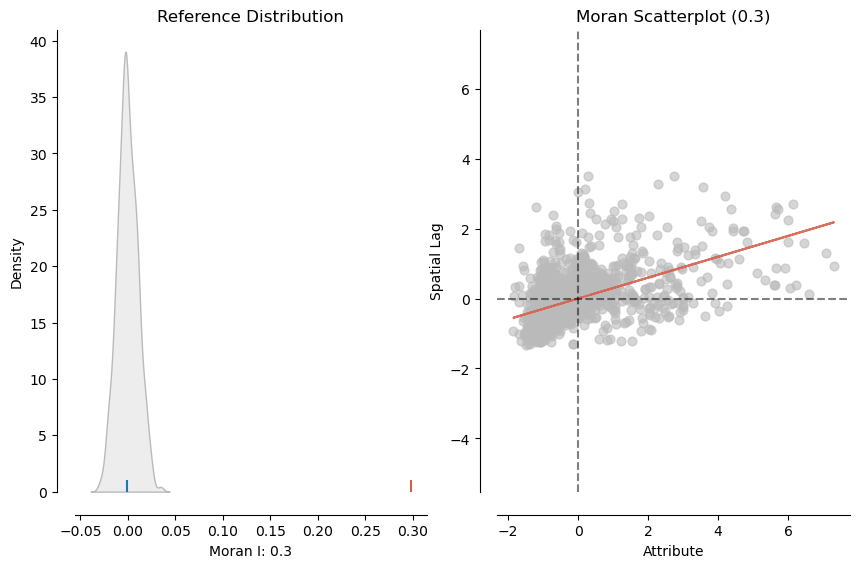


Gráfico de diagnóstico de Moran guardado en: C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\grafico_diagnostico_moran.png


In [19]:
#CÁLCULO NUMÉRICO DEL ÍNDICE DE MORAN GLOBAL

# 1. Calcular el objeto Moran
# Usamos los residuos originales (no los estandarizados) y la matriz de pesos estandarizada.
moran_global = Moran(grid_model['resid_dev'], w)

# 2. Presentar los resultados numéricos
print(f"\nResultados del Índice de Moran Global:")
# El valor del índice. Un valor > 0 indica autocorrelación positiva (agrupamiento de valores similares).
print(f"  - Índice de Moran (I): {moran_global.I:.4f}")

# El p-valor basado en simulaciones (permutaciones). Es la medida de significancia más robusta.
print(f"  - P-valor (p_sim):   {moran_global.p_sim:.4f}")

# El Z-score asociado a la simulación.
print(f"  - Z-score (z_sim):   {moran_global.z_sim:.4f}")

# 3. Interpretación de los resultados
if moran_global.p_sim < 0.05:
    print("\n  Interpretación: El p-valor es estadísticamente significativo.")
    print("  Podemos rechazar la hipótesis nula de que los residuos están distribuidos aleatoriamente.")
    print("  La evidencia apunta a una fuerte autocorrelación espacial positiva, lo que confirma")
    print("  que el modelo GLM no ha capturado toda la estructura espacial de los datos.")
else:
    print("\n  Interpretación: El p-valor no es significativo.")
    print("  No podemos rechazar la hipótesis de que los residuos están distribuidos aleatoriamente.")
    

# 4. Generar el gráfico combinado de Moran

print("\nGenerando gráfico de diagnóstico de Moran...")
plot_moran(moran_global, figsize=(10,6))

# Guardar y mostrar la figura
output_path_moran_diagnostic = os.path.join(output_dir, 'grafico_diagnostico_moran.png')
plt.savefig(output_path_moran_diagnostic, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nGráfico de diagnóstico de Moran guardado en: {output_path_moran_diagnostic}")


--- Generando panel de mapas de diagnóstico LISA con layout final... ---


<Axes: >

<Axes: >

Text(0.5, 1.01, 'Valores de I de Moran Local (`Is`)')

<Axes: >

<Axes: >

Text(0.5, 1.01, 'Cuadrantes de Moran (Sin Filtro de Significancia)')

<Axes: >

<Axes: >

Text(0.5, 1.01, 'Mapa de Significancia de LISA')

<Axes: >

<Axes: >

Text(0.5, 1.01, 'Mapa de Clústeres LISA (Significativos)')

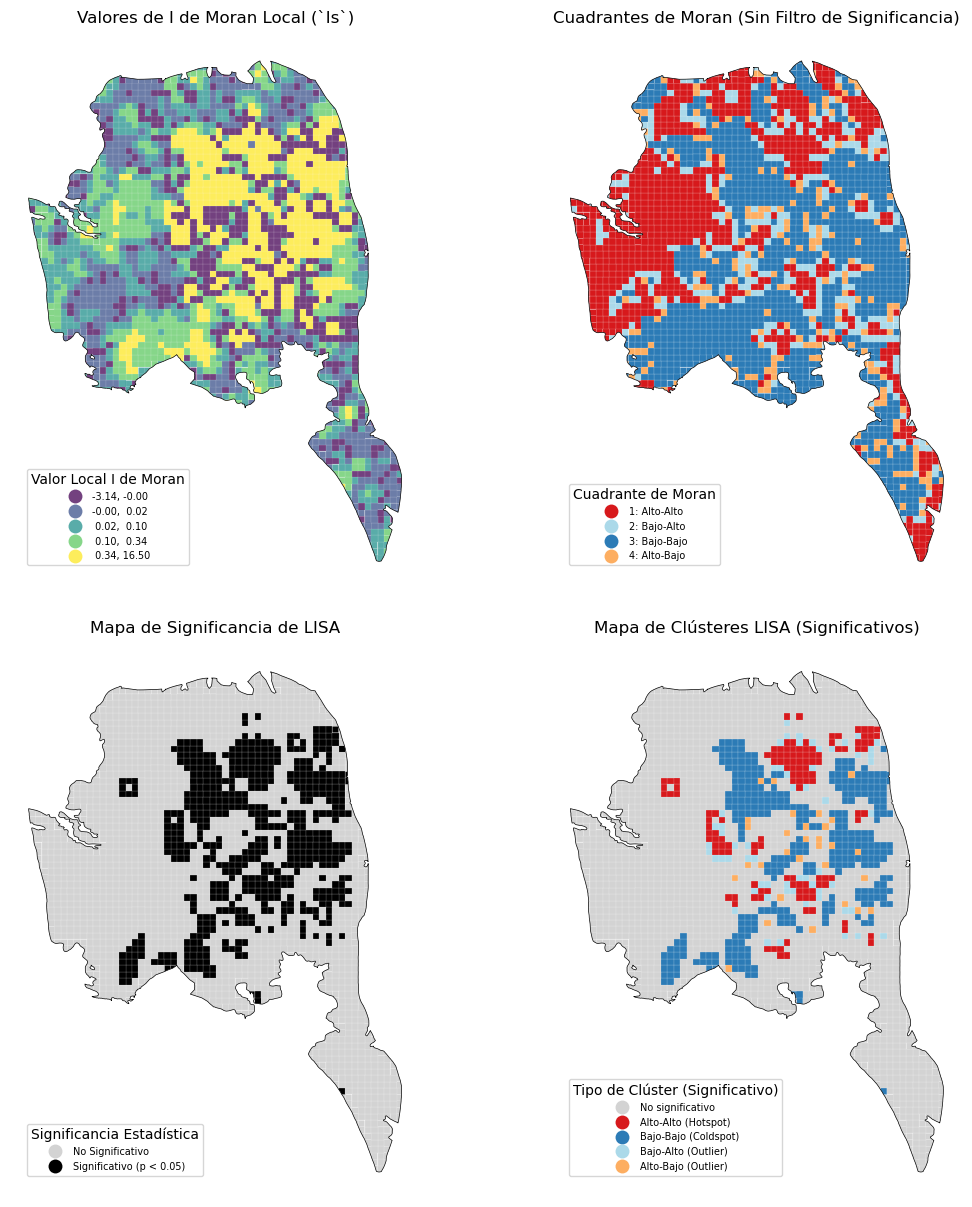


Panel de mapas LISA con layout final guardado en: C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\panel_desglose_LISA_final.png


In [32]:
# DESGLOSE VISUAL DE LOS RESULTADOS DE LISA 
# =============================================================================

# 1. Crear la figura con 4 subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axs = axs.flatten()

# --- Definimos la posición y estilo para todos los títulos y leyendas ---
TITLE_Y_POS = 1.01
LEGEND_LOC = 'lower left'
# AJUSTE: Movemos el ancla un poco más hacia arriba y la derecha
LEGEND_BBOX = (0.03, 0.03) 
LEGEND_FONT_SIZE = 7

# --- Mapa 1 (Superior Izquierda): Valores Locales I de Moran (Is) ---
ax = axs[0]
grid_model.plot(
    column='lisa_Is', cmap='viridis', scheme='quantiles', k=5,
    edgecolor='white', linewidth=0.1, alpha=0.75, legend=True, ax=ax,
    legend_kwds={'title': "Valor Local I de Moran", 'loc': LEGEND_LOC, 'bbox_to_anchor': LEGEND_BBOX, 'prop': {'size': LEGEND_FONT_SIZE}}
)
gdf_contour.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)
ax.set_title("Valores de I de Moran Local (`Is`)", y=TITLE_Y_POS)
ax.set_axis_off()

# --- Mapa 2 (Superior Derecha): Cuadrantes del Gráfico de Moran ---
ax = axs[1]
q_labels = ['1: Alto-Alto', '2: Bajo-Alto', '3: Bajo-Bajo', '4: Alto-Bajo']
labels = [q_labels[i-1] for i in lisa.q]
hmap = ListedColormap(['#d7191c', '#abd9e9', '#2c7bb6', '#fdae61'])
grid_model.assign(cl=labels).plot(
    column='cl', categorical=True, cmap=hmap, linewidth=0.1, ax=ax, 
    edgecolor='white', legend=True,
    legend_kwds={'title': "Cuadrante de Moran", 'loc': LEGEND_LOC, 'bbox_to_anchor': LEGEND_BBOX, 'prop': {'size': LEGEND_FONT_SIZE}}
)
gdf_contour.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)
ax.set_title("Cuadrantes de Moran (Sin Filtro de Significancia)", y=TITLE_Y_POS)
ax.set_axis_off()

# --- Mapa 3 (Inferior Izquierda): Mapa de Significancia ---
ax = axs[2]
sig = 1 * (lisa.p_sim < 0.05)
hmap = ListedColormap(['lightgrey', 'black'])
labels = ['No Significativo', 'Significativo (p < 0.05)']
labels = [labels[i] for i in sig]
grid_model.assign(cl=labels).plot(
    column='cl', categorical=True, cmap=hmap, linewidth=0.1, ax=ax,
    edgecolor='white', legend=True,
    legend_kwds={'title': "Significancia Estadística", 'loc': LEGEND_LOC, 'bbox_to_anchor': LEGEND_BBOX, 'prop': {'size': LEGEND_FONT_SIZE}}
)
gdf_contour.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)
ax.set_title("Mapa de Significancia de LISA", y=TITLE_Y_POS)
ax.set_axis_off()

# --- Mapa 4 (Inferior Derecha): Mapa de Clústeres LISA (El Resultado Final) ---
ax = axs[3]
colors_dict = {
    'No significativo': 'lightgrey', 'Alto-Alto (Hotspot)': '#d7191c', 
    'Bajo-Bajo (Coldspot)': '#2c7bb6', 'Bajo-Alto (Outlier)': '#abd9e9', 
    'Alto-Bajo (Outlier)': '#fdae61'
}
category_order = ['No significativo', 'Alto-Alto (Hotspot)', 'Bajo-Bajo (Coldspot)', 'Bajo-Alto (Outlier)', 'Alto-Bajo (Outlier)']
cats_in_data = [cat for cat in category_order if cat in grid_model['lisa_significant_cluster'].unique()]
grid_model['lisa_significant_cluster'] = pd.Categorical(grid_model['lisa_significant_cluster'], categories=cats_in_data, ordered=True)
plot_colors = [colors_dict[cat] for cat in grid_model['lisa_significant_cluster'].cat.categories]
custom_cmap = plt.cm.colors.ListedColormap(plot_colors)
grid_model.plot(
    column='lisa_significant_cluster', categorical=True, cmap=custom_cmap,
    linewidth=0.1, ax=ax, edgecolor='white', legend=True,
    legend_kwds={'title': "Tipo de Clúster (Significativo)", 'loc': LEGEND_LOC, 'bbox_to_anchor': LEGEND_BBOX, 'prop': {'size': LEGEND_FONT_SIZE}}
)
gdf_contour.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)
ax.set_title("Mapa de Clústeres LISA (Significativos)", y=TITLE_Y_POS)
ax.set_axis_off()

# Ajustamos el layout general para reducir el espaciado
fig.tight_layout(pad=0.5, h_pad=2.5) # AJUSTE: Reducido el padding general
output_path_lisa_panel = os.path.join(output_dir, 'panel_desglose_LISA_final.png')
plt.savefig(output_path_lisa_panel, dpi=300)
plt.show()

print(f"\nPanel de mapas LISA con layout final guardado en: {output_path_lisa_panel}")


--- Generando Gráfico de Moran con estética final... ---


(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': 'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>)

Text(0.05, 0.95, 'MI = 0.30')

Text(0.5, 0, 'Residuos (Estandarizados)')

Text(0, 0.5, 'Lag Espacial')

Text(0.5, 1.0, 'Moran Local Scatterplot de Residuos')

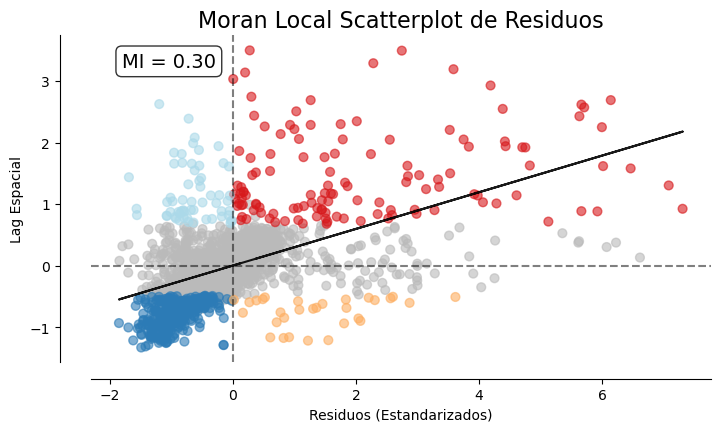


Gráfico de Moran final guardado en: C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\grafico_moran_final.png


In [34]:
# =============================================================================
# GRÁFICO DE MORAN CON ESTÉTICA FINAL
# =============================================================================

from splot.esda import moran_scatterplot
import matplotlib.pyplot as plt
import os

# Creamos la figura y el eje
fig, ax = plt.subplots(figsize=(8, 8))

# Usamos la función de splot para generar el gráfico
moran_scatterplot(lisa, p=0.05, ax=ax)

# Añadimos la anotación con el formato "MI = ..."
#    Usamos .2f para redondear a 2 decimales, como en el ejemplo.
ax.text(0.05, 0.95, f'MI = {moran_global.I:.2f}', 
        transform=ax.transAxes, ha='left', va='top', fontsize=14,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

#  Personalizamos los títulos de los ejes para que sean más simples
ax.set_xlabel("Residuos (Estandarizados)")
ax.set_ylabel("Lag Espacial")

#  Adecuamos el título de la figura
ax.set_title('Moran Local Scatterplot', fontsize=16)

# Guardamos la figura
output_path_moran_final = os.path.join(output_dir, 'grafico_moran_final.png')
plt.savefig(output_path_moran_final, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nGráfico de Moran final guardado en: {output_path_moran_final}")


--- Iniciando la búsqueda del número óptimo de clústeres (k)... ---

Generando Dendrograma...


<Figure size 1500x800 with 0 Axes>

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [12.5, 12.5, 42.5, 42.5],
  [65.0, 65.0, 75.0, 75.0],
  [85.0, 85.0, 95.0, 95.0],
  [70.0, 70.0, 90.0, 90.0],
  [105.0, 105.0, 115.0, 115.0],
  [135.0, 135.0, 145.0, 145.0],
  [125.0, 125.0, 140.0, 140.0],
  [110.0, 110.0, 132.5, 132.5],
  [80.0, 80.0, 121.25, 121.25],
  [27.5, 27.5, 100.625, 100.625]],
 'dcoord': [[0.0, 2.657350573786216, 2.657350573786216, 0.0],
  [0.0, 7.611939302296653, 7.611939302296653, 2.657350573786216],
  [0.0, 3.1980797447546063, 3.1980797447546063, 0.0],
  [0.0, 10.000197918916447, 10.000197918916447, 3.1980797447546063],
  [7.611939302296653,
   22.110068752897227,
   22.110068752897227,
   10.000197918916447],
  [0.0, 2.802628051854706, 2.802628051854706, 0.0],
  [0.0, 3.054851640862921, 3.054851640862921, 0.0],
  [2.802628051854706, 7.543952683174712, 7.543952683174712, 3.054851640862921],
  [0.0, 6.003935312460545, 6.003935312460545, 

Text(0.5, 1.0, 'Dendrograma del Clustering Jerárquico de Residuos')

Text(0.5, 0, 'Índice del Clúster (o número de celdas en el clúster)')

Text(0, 0.5, 'Distancia de Fusión (Ward)')

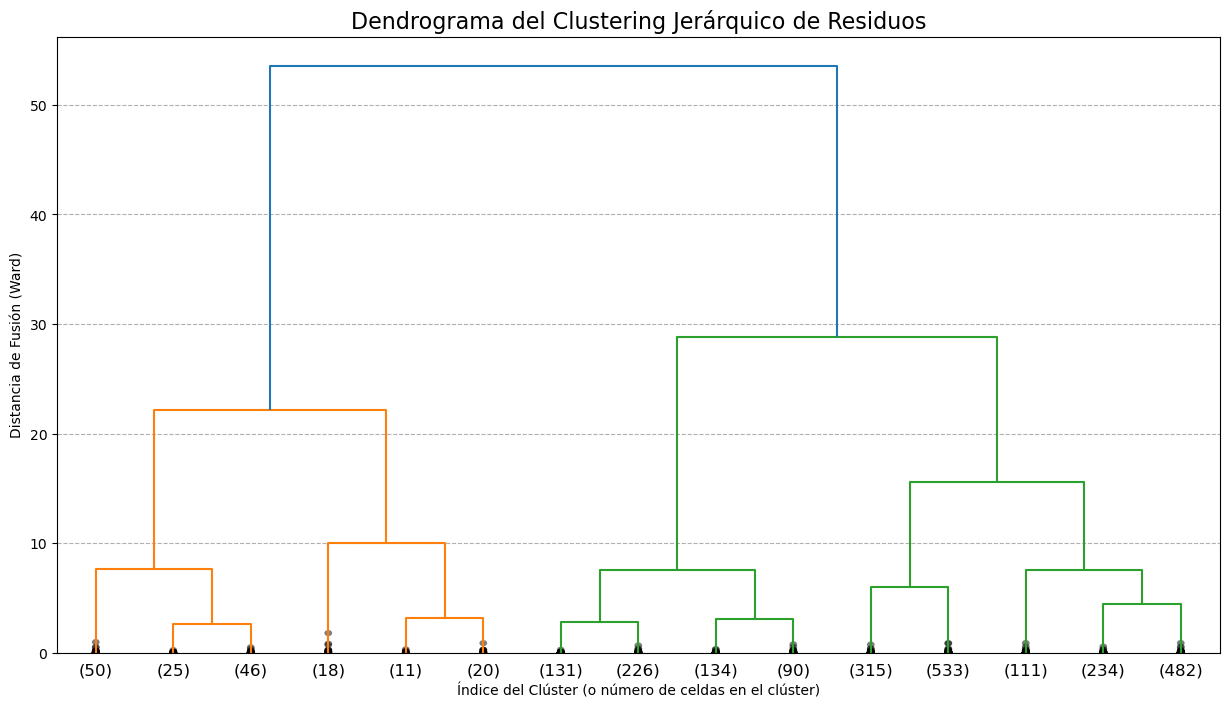


Calculando Silhouette Score para diferentes valores de k...
  Para k=2, Silhouette Score = 0.3787
  Para k=3, Silhouette Score = 0.3342
  Para k=4, Silhouette Score = 0.3594
  Para k=5, Silhouette Score = 0.3681
  Para k=6, Silhouette Score = 0.3816
  Para k=7, Silhouette Score = 0.3670
  Para k=8, Silhouette Score = 0.3718
  Para k=9, Silhouette Score = 0.3772
  Para k=10, Silhouette Score = 0.3763


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Silhouette Score para Diferentes Números de Clústeres (k)')

Text(0.5, 0, 'Número de Clústeres (k)')

Text(0, 0.5, 'Silhouette Score')

([<matplotlib.axis.XTick at 0x19386ac38f0>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

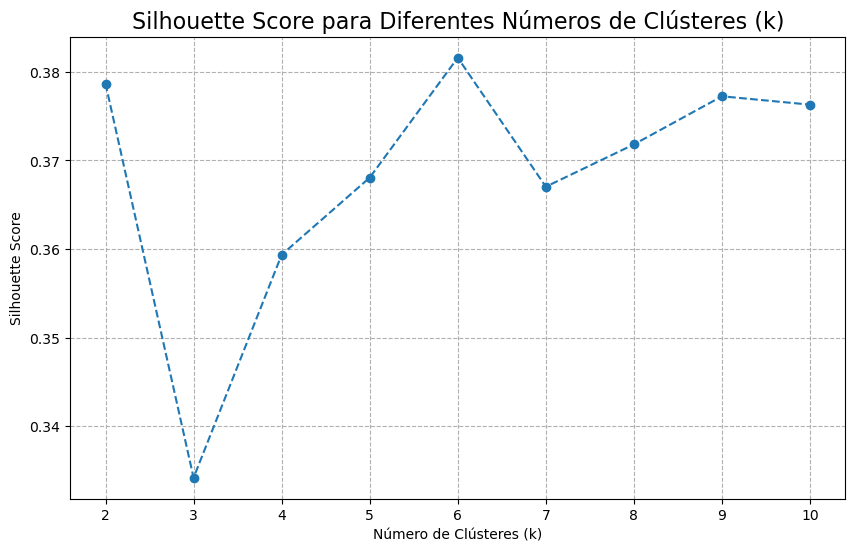


El número óptimo de clústeres según el Silhouette Score es: k = 6


In [41]:
# =============================================================================
# PASO ADICIONAL: DETERMINACIÓN ESTADÍSTICA DEL NÚMERO DE CLÚSTERES (k)
# =============================================================================
# Este bloque asume que 'grid_model' (con 'resid_dev') y 'w_original' están en memoria.

# --- Re-importamos librerías ---
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
import os

print("\n--- Iniciando la búsqueda del número óptimo de clústeres (k)... ---")

# 1. Preparar los datos para el clustering (Residuos estandarizados)
scaler = StandardScaler()
data_to_cluster = scaler.fit_transform(grid_model[['resid_dev']])


# -----------------------------------------------------------------------------
# MÉTODO 1: DENDROGRAMA VISUAL
# -----------------------------------------------------------------------------
print("\nGenerando Dendrograma...")
# Calculamos la matriz de linkage usando el método 'ward'
linked = linkage(data_to_cluster, method='ward', metric='euclidean')

# Graficamos el Dendrograma
plt.figure(figsize=(15, 8))
dendrogram(
    linked,
    orientation='top',
    truncate_mode='lastp', # Muestra solo las últimas 'p' fusiones para que sea legible
    p=15, # Puedes ajustar este número para ver más o menos detalle
    show_leaf_counts=True,
    show_contracted=True,
)
plt.title('Dendrograma del Clustering Jerárquico de Residuos', fontsize=16)
plt.xlabel("Índice del Clúster (o número de celdas en el clúster)")
plt.ylabel("Distancia de Fusión (Ward)")
plt.grid(axis='y', linestyle='--')
output_path_dendrogram = os.path.join(output_dir, 'dendrograma_residuos.png')
plt.savefig(output_path_dendrogram, dpi=300)
plt.show()


# -----------------------------------------------------------------------------
# MÉTODO 2: SILHOUETTE SCORE CUANTITATIVO
# -----------------------------------------------------------------------------
print("\nCalculando Silhouette Score para diferentes valores de k...")
# Definimos un rango de k para probar
k_range = range(2, 11) # Probaremos de 2 a 10 clústeres
silhouette_scores = []

for k in k_range:
    # Ajustamos el modelo de clustering para cada k
    agg_cluster_model = AgglomerativeClustering(n_clusters=k, connectivity=w_original.sparse)
    labels = agg_cluster_model.fit_predict(data_to_cluster)
    
    # Calculamos el Silhouette Score y lo guardamos
    score = silhouette_score(data_to_cluster, labels)
    silhouette_scores.append(score)
    print(f"  Para k={k}, Silhouette Score = {score:.4f}")

# Graficamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score para Diferentes Números de Clústeres (k)', fontsize=16)
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True, linestyle='--')
output_path_silhouette = os.path.join(output_dir, 'silhouette_score_plot.png')
plt.savefig(output_path_silhouette, dpi=300)
plt.show()

# Encontrar el k óptimo
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nEl número óptimo de clústeres según el Silhouette Score es: k = {optimal_k}")


--- Generando mapa de regionalización final con estética cartográfica... ---


<Axes: >

<Axes: >

Text(0.5, 102.72222222222219, 'Coordenada Este (m)')

Text(215.4487739779001, 0.5, 'Coordenada Norte (m)')

(array([4717000., 4718000., 4719000., 4720000., 4721000., 4722000.,
        4723000., 4724000.]),
 [Text(4717000.0, 0, '4717000'),
  Text(4718000.0, 0, '4718000'),
  Text(4719000.0, 0, '4719000'),
  Text(4720000.0, 0, '4720000'),
  Text(4721000.0, 0, '4721000'),
  Text(4722000.0, 0, '4722000'),
  Text(4723000.0, 0, '4723000'),
  Text(4724000.0, 0, '4724000')])

Text(0.95, 0.97, 'N')

Text(0.5, 1.0, 'Regionalización de Residuos del Modelo (k=4)')

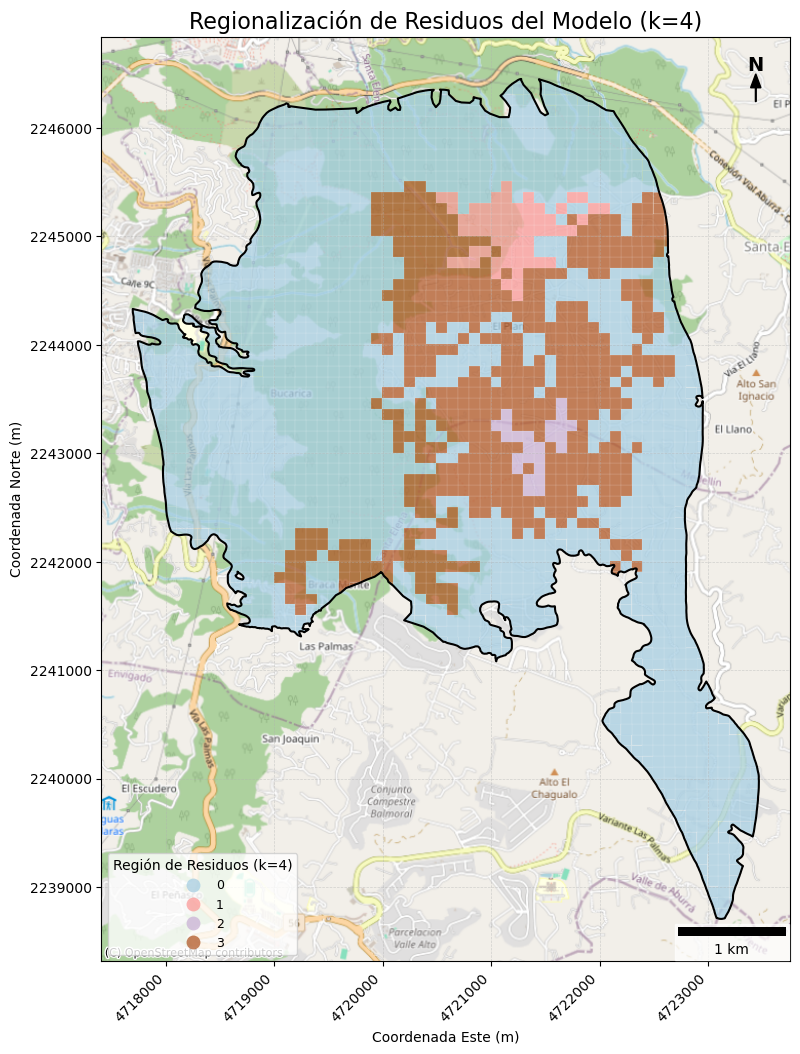


Mapa de regionalización final guardado en: C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\mapa_regiones_residuos_k4_final.png


In [45]:
#  MAPA DE REGIONALIZACIÓN (k=4) 

import matplotlib.pyplot as plt
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar
import geopandas as gpd
import pandas as pd
import os


# 1. Crear la figura
fig, ax = plt.subplots(figsize=(12, 12))

# 2. Mapear el resultado de la regionalización

grid_model.plot(
    column='region_k4',
    categorical=True,
    legend=True,
    ax=ax,
    cmap='Paired', # Un buen mapa de colores para categorías
    edgecolor='white',
    linewidth=0.1,
    alpha=0.75, # Transparencia para ver el mapa base
    # AJUSTE: Ubicación y estilo de la leyenda
    legend_kwds={
        'title': "Región de Residuos (k=4)", 
        'loc': 'lower left', 
        'prop': {'size': 9},
        'frameon': True,
        'facecolor': 'white',
        'framealpha': 0.8
    }
)

# 3. Añadir el contorno del área de estudio
gdf_contour.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5)

# 4. Añadir el mapa base de fondo
cx.add_basemap(ax, crs=grid_model.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik, zoom='auto')

# 5. Añadir la cuadrícula de coordenadas y etiquetas de los ejes
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
ax.set_xlabel("Coordenada Este (m)")
ax.set_ylabel("Coordenada Norte (m)")
ax.ticklabel_format(style='plain', useOffset=False)
plt.xticks(rotation=45, ha='right')

# 6. Añadir la barra de escala
ax.add_artist(ScaleBar(dx=1, units="m", location="lower right", frameon=True, color='black', box_alpha=0.7))

# 7. Añadir la flecha de norte
x_n, y_n = 0.95, 0.97
ax.text(x_n, y_n, "N", transform=ax.transAxes, ha="center", va="center", fontsize=14, fontweight="bold", zorder=5)
ax.arrow(x_n, y_n - 0.04, 0, 0.03, transform=ax.transAxes,
         head_width=0.015, head_length=0.015, fc='black', ec='black',
         length_includes_head=True, zorder=5)

ax.set_title("Regionalización de Residuos del Modelo (k=4)", fontsize=16)
output_path_regions_final = os.path.join(output_dir, 'mapa_regiones_residuos_k4_final.png')
# Usamos bbox_inches='tight' para asegurar que todos los elementos queden dentro de la imagen guardada
plt.savefig(output_path_regions_final, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nMapa de regionalización final guardado en: {output_path_regions_final}")


--- Generando Diagrama de Cajas y Bigotes con colores exactos del mapa... ---


<Axes: xlabel='region_k4_str', ylabel='resid_dev'>

Text(0.5, 1.0, 'Distribución de Residuos por Región Encontrada (k=4)')

Text(0.5, 0, 'ID de la Región')

Text(0, 0.5, 'Residuo de Deviance')

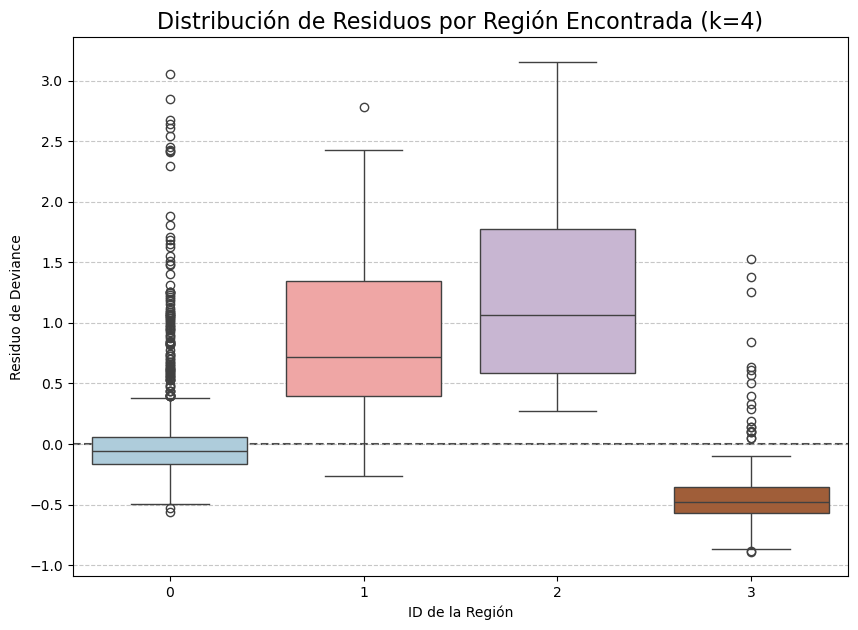


Resumen numérico de los residuos por cada región:
            count      mean       std       min       25%       50%       75%  \
region_k4                                                                       
0          1781.0 -0.006049  0.344926 -0.558923 -0.168373 -0.055160  0.053564   
1            63.0  0.890907  0.700055 -0.266143  0.392689  0.716794  1.347186   
2            25.0  1.206263  0.794773  0.270881  0.584569  1.067583  1.777205   
3           557.0 -0.445134  0.237450 -0.889291 -0.566226 -0.475254 -0.359038   

                max  
region_k4            
0          3.055460  
1          2.782390  
2          3.155080  
3          1.524878  


In [52]:

# DIAGRAMA DE CAJAS CON COLORES EXACTOS DEL MAPA (k=4)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# 1. Se Crea la paleta de colores para que coincida con el mapa anterior

color_palette = {
    '0': '#a6cee3', # Un azul claro exacto
    '1': '#fb9a99', # Un rojo/rosa claro exacto
    '2': '#cab2d6', # Un púrpura claro exacto
    '3': '#b15928'  # Un marrón/naranja oscuro exacto
}

# 2. Preparamos los datos para el ploteo
# Convertimos la columna de la región a string para que coincida con las llaves de la paleta.
grid_model['region_k4_str'] = grid_model['region_k4'].astype(str)
# Definimos el orden numérico para el eje X.
plot_order = [str(i) for i in sorted(grid_model['region_k4'].unique())]


# 3. Generamos el gráfico de cajas usando la paleta de colores personalizada
fig, ax = plt.subplots(figsize=(10, 7))

sns.boxplot(
    x='region_k4_str', 
    y='resid_dev', 
    hue='region_k4_str',
    data=grid_model, 
    ax=ax, 
    palette=color_palette, 
    order=plot_order,
    legend=False
)

# 4. Añadimos una línea de referencia en cero y damos formato
ax.axhline(0, color='black', linestyle='--', alpha=0.7, zorder=0)
ax.set_title('Distribución de Residuos por Región Encontrada (k=4)', fontsize=16)
ax.set_xlabel('ID de la Región')
ax.set_ylabel('Residuo de Deviance')
ax.grid(axis='y', linestyle='--', alpha=0.7)

# 5. Guardamos la figura
output_path_boxplot_final = os.path.join(output_dir, 'boxplot_regiones_k4_colores_finales.png')
plt.savefig(output_path_boxplot_final, dpi=300, bbox_inches='tight')
plt.show()

# Imprimimos el resumen numérico que nos ayuda a interpretar las cajas
print("\nResumen numérico de los residuos por cada región:")
print(grid_model.groupby('region_k4')['resid_dev'].describe())